## Analysis of the simpler Nuclear Shell model Hamiltonian

#### Imports

In [1]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type
from scipy.optimize import minimize
from tqdm import trange
from src.qml_utils.utils import Schedule,SchedulerModel
from scipy.sparse import csr_matrix, diags
from numpy.linalg import eigh

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Hyperparameters of the model

In [ ]:
nlevels=3

tf=20
nsteps=100
number_of_parameters=10


file_name:str='data/cki'
qq_filename:str='data/qq.p'
pairing_filename:str='data/pair_inter.p'

j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=2
nparticles_b:int=2

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{8}$Be'

#### The target Hamiltonian

In [132]:
# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
egs=egs[0]
print(egs)
psi0=psis[:,:1]

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.99it/s]
1424it [00:01, 738.79it/s]


size= 12 6
Hamiltonian shape= (51, 51)
-30.29539461360555


#### Define the simpler Hamiltonian

Hyperparameters

In [ ]:
pairing_coupling=+1
quadrupole_coupling=+2

In [134]:
matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)
QQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
QQoperator.get_twobody_interaction(twobody_dict=matrix_qq)
QQoperator.get_hamiltonian()


matrix_pairing,_=get_twobody_nuclearshell_model(file_name=pairing_filename)
PPoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
PPoperator.get_twobody_interaction(twobody_dict=matrix_pairing)
PPoperator.get_hamiltonian()
mean_field_hamiltonian=diags(TargetHamiltonian.hamiltonian.diagonal(), format='csr')


simpler_target_hamiltonian=(mean_field_hamiltonian+pairing_coupling*PPoperator.hamiltonian+quadrupole_coupling*QQoperator.hamiltonian)

eigenvalues,eigenstates=eigh(simpler_target_hamiltonian.todense())

print('egs simpler=',eigenvalues[0],'eigenstates=',eigenstates.shape)




Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  6.02it/s]
1256it [00:01, 754.84it/s]


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  9.85it/s]
216it [00:00, 721.30it/s]


egs simpler= -35.662755681199414 eigenstates= (51, 51)


#### Analysis of the overlap with respect to the eigenstates of the Simpler NSM

[-35.66275568 -29.1728046  -19.54369172 -17.03277999 -16.00975794
 -15.27950908 -15.0426764  -13.10505737 -12.49316858 -12.17080446
 -10.85089192 -10.05065244  -9.81729087  -8.78126761  -8.62395714
  -8.56204601  -8.25718831  -8.24960629  -7.82836972  -6.82385931
  -5.73266857  -4.99359003  -3.69194833  -3.24381941  -2.86601461
  -2.39064909  -2.04865307  -1.97081543  -1.84386673  -1.33621953
  -0.90627517  -0.61181951  -0.19489472  -0.08300425   0.29128786
   0.61834209   0.88864996   1.14500836   1.38676706   2.08037184
   2.3500118    2.52518589   2.56443754   2.57597174   3.22085415
   3.62965172   3.87827126   4.10619585   4.42048854   4.45502242
   4.9531358 ]


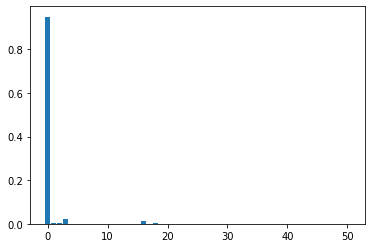

In [135]:
overlap=np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates)*np.conjugate(np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates))
print(eigenvalues)
plt.bar(np.arange(overlap.shape[0]),overlap)
plt.show()

#### Quantum Optimal Control with the simpler Hamiltonian

Initialize the initial Hamiltonian

In [136]:
min_b=np.zeros(size_a+size_b)
min_b[0]=1
#min_b[1]=1
min_b[3]=1
#min_b[5]=1

min_b[0+size_a]=1
#min_b[1+size_a]=1
#min_b[2+size_a]=1
min_b[3+size_a]=1




print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()


initial state= [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
idx= 5
min energy= -15.405709999999996


In [137]:
model=SchedulerModel(initial_state=psi_configuration,target_hamiltonian=mean_field_hamiltonian+pairing_coupling*PPoperator.hamiltonian+quadrupole_coupling*QQoperator.hamiltonian,initial_hamiltonian=InitialHamiltonian.hamiltonian,tf=tf,nsteps=nsteps,number_of_parameters=number_of_parameters,type='fourier',seed=42,reference_hamiltonian=TargetHamiltonian.hamiltonian,mode='annealing ansatz')
print(model.parameters.shape)

res = minimize(
                    model.forward,
                    model.parameters,
                    method='L-BFGS-B',
                    tol=10**-6,
                    callback=model.callback,
                    options=None,
                    
                )

model.parameters = res.x
energy = model.forward(model.parameters)
print(energy,egs)
print(model.parameters)

(80,)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:579: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/scipy/optimize/lbfgsb.py:351: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


(-29.31783954192632+8.881784197001252e-16j)
(-29.334779324818083+0j)
(-29.33554299942979+0j)
(-29.335827382935594+3.552713678800501e-15j)
(-29.338391585924786-3.552713678800501e-15j)
(-29.356277842380766+0j)
(-29.3584799359166+0j)
(-29.370314048015516+0j)
(-29.526966866489538-1.7763568394002505e-15j)
(-29.52787706712114+0j)
(-29.547401596994593-1.7763568394002505e-15j)
(-29.557241450682525-4.440892098500626e-16j)
(-29.569562668325588+5.551115123125783e-17j)
(-29.591714539828644+5.551115123125783e-17j)
(-29.605924815113816+8.881784197001252e-16j)
(-29.621973059615144+0j)
(-29.646253721063093+0j)
(-29.65175639165049-1.7763568394002505e-15j)
(-29.663447552671915+0j)
(-29.68260349533225-1.7763568394002505e-15j)
(-29.694457347817302+0j)
(-29.69880182632331-1.7763568394002505e-15j)
(-29.721505328658676+1.7763568394002505e-15j)
(-29.781327250548784+1.7763568394002505e-15j)
(-29.808812656163347+1.7763568394002505e-15j)
(-29.837104712275+0j)
(-29.852808360372514-1.7763568394002505e-15j)
(-29.85

#### Analysis of the Optimization

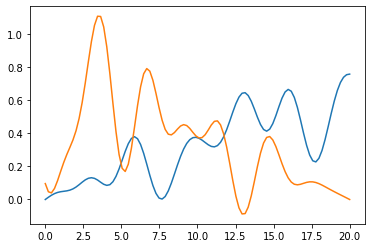

(51, 1)
(0.9951966912698275+0j)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


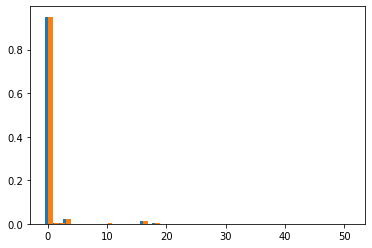

In [139]:
hd,ht=model.get_driving()

plt.plot(model.time,ht)
plt.plot(model.time,hd)
plt.show()


overlap_optimization=np.einsum('i,ia->a',model.psi.conjugate(),eigenstates)*np.conjugate(np.einsum('i,ia->a',model.psi.conjugate(),eigenstates))
print(psi0.shape)
print((psi0[:,0].conjugate().dot(model.psi))*np.conjugate((psi0[:,0].conjugate().dot(model.psi))))
plt.bar(np.arange(overlap.shape[0]),overlap)
plt.bar(np.arange(overlap.shape[0])+0.5,overlap_optimization)
plt.show()
